In [9]:
import json
import matplotlib.pyplot as plt

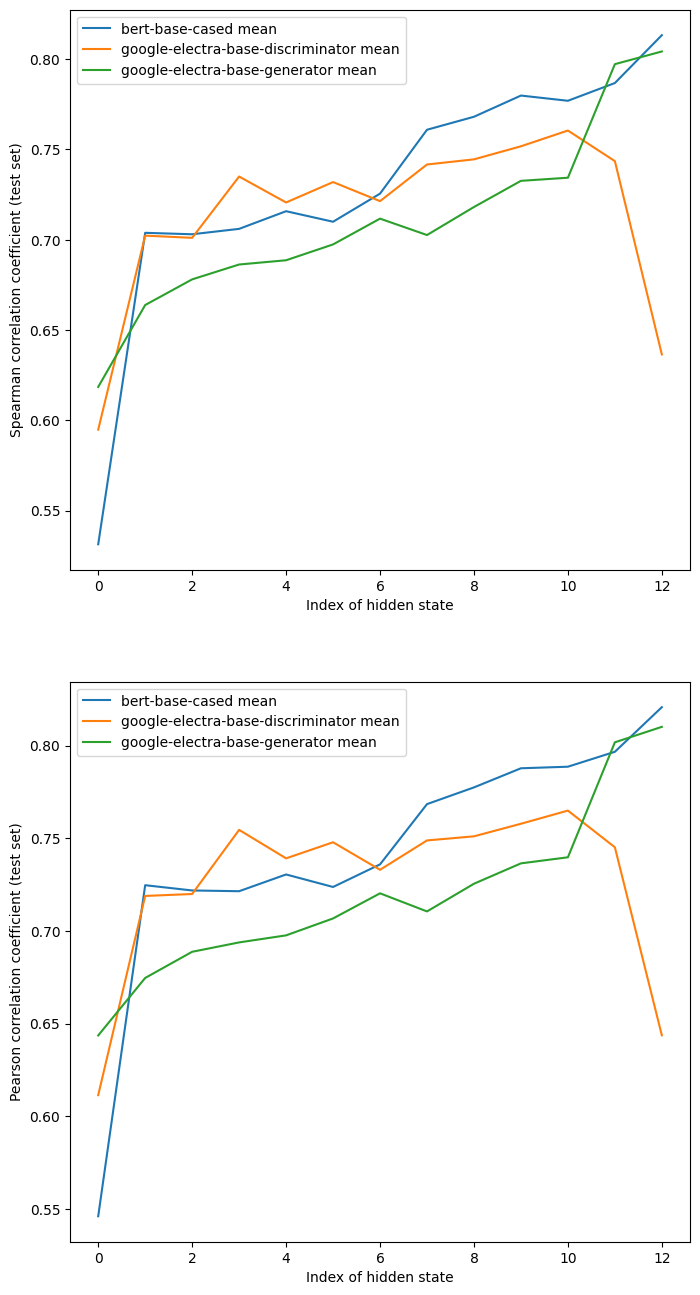

In [22]:
models = ["bert-base-cased", "google-electra-base-discriminator", "google-electra-base-generator"]

fig, axs = plt.subplots(2, 1, figsize=(8, 16))

for m in models:
    spearman, pearson = [], []
    for i in range(13):
        res = json.load(open(f"../output/{m}_mean_{i}_to_{i+1}/test_results.json"))
        spearman.append(res["mean_cosine_spearman_test"])
        pearson.append(res["mean_cosine_pearson_test"])
        
    axs[0].plot(spearman, label=f"{m} mean")
    axs[0].set_xlabel("Index of hidden state")
    axs[0].set_ylabel("Spearman correlation coefficient (test set)")
    axs[0].legend()
    
    axs[1].plot(pearson, label=f"{m} mean")
    axs[1].set_xlabel("Index of hidden state")
    axs[1].set_ylabel("Pearson correlation coefficient (test set)")
    axs[1].legend()
